### IDENTIFYING THE BEST PLAYERS IN TERMS OF PASSES THAT LEAD TO A SHOT OR GOAL IN THE WORLD CUP 2022

In [4]:
from statsbombpy import sb
import pandas as pd
import numpy as np

##### Read and clean the data

In [2]:
# Read the WC 2022 data
df=pd.DataFrame(sb.matches(competition_id=43, season_id=106))

passes_global = pd.DataFrame()  # DataFrame for the passes
shots_global = pd.DataFrame()   # DataFrame for the shots

for match in df.match_id.unique():
    event = sb.events(match_id=match)
    passes = event[event['type']=='Pass']
    shots = event[event['type']=='Shot']

    passes_global = pd.concat([passes_global, passes], ignore_index=True)
    shots_global = pd.concat([shots_global, shots], ignore_index=True)


c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-pack

##### Get the passes that lead to a shot or goal

In [3]:
# Filter for passes that lead to a shot or a goal
goal_and_shot_assists = passes_global[(passes_global['pass_goal_assist'] == True) | (passes_global['pass_shot_assist'] == True)]

# Get the interested columns
goal_and_shot_assists = goal_and_shot_assists[['id','location','pass_assisted_shot_id','pass_end_location',
                                              'player','position','team','pass_goal_assist','pass_shot_assist','play_pattern']]


##### Get the shots from passes

In [5]:
# Get the xG of the shots from passes
players_xg = pd.DataFrame(columns=['player', 'team', 'xG','play_pattern'])

for index, row in goal_and_shot_assists.iterrows():
    player = row['player']
    play_pattern = row['play_pattern']
    id_shot = row['pass_assisted_shot_id']
    team = row['team']
    for shot in shots_global.id.unique():
        if id_shot == shot:
            xG = shots_global[shots_global['id'] == id_shot]['shot_statsbomb_xg'].values[0]
            data = {'player': player, 'team': team, 'xG': xG, 'play_pattern':play_pattern}
            data = pd.DataFrame([data])
            players_xg = pd.concat([players_xg, data], ignore_index=True)

# Identify which play patterns are regular plays and which are set pieces
regular_plays = ['Regular Play', 'From Counter','Other','From Keeper','From Goal Kick','From Kick Off']
players_xg['play_pattern'] = np.where(players_xg['play_pattern'].isin(regular_plays), 'Regular Play', 'Setpieces')

#Player = Player - Team
players_xg['player'] = players_xg['player'] + ' - ' + players_xg['team']
display(players_xg.head())

,player,team,xG,play_pattern
0,Xherdan Shaqiri - Switzerland,Switzerland,0.353289,Regular Play
1,Dušan Tadić - Serbia,Serbia,0.081609,Setpieces
2,Dušan Tadić - Serbia,Serbia,0.030002,Regular Play
3,Ruben Vargas - Switzerland,Switzerland,0.096118,Setpieces
4,Djibril Sow - Switzerland,Switzerland,0.069699,Setpieces


##### Identify the players with the most xG from their passes

In [6]:
top = players_xg.groupby('player', as_index=False)['xG'].sum().sort_values(by='xG', ascending=False)
top_players = top['player'].head(10).tolist()

##### Barchart of the xG from each player for each play pattern (Regular Play, Set pieces)

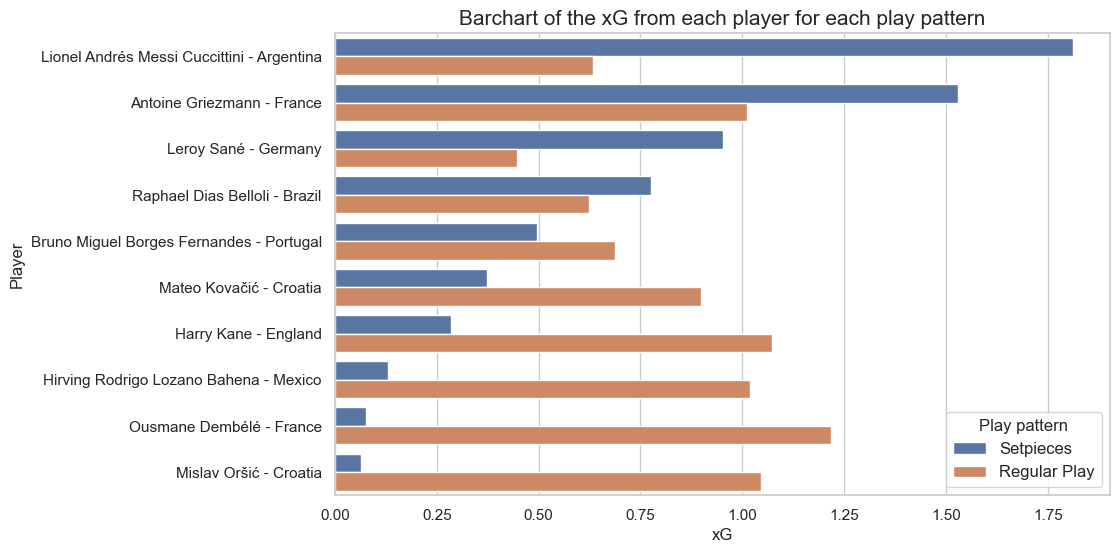

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

data = players_xg[players_xg['player'].isin(top_players)]
data = data.groupby(['player','play_pattern'])['xG'].sum().reset_index()
data = data.sort_values(by=['play_pattern','xG'], ascending=False)

plt.figure(figsize=(10, 6)) 
sns.set(style="whitegrid")

plot = sns.barplot(x='xG', y='player', hue='play_pattern', data=data, orient='h')

plt.xlabel('xG')
plt.ylabel('Player')
plt.title('Barchart of the xG from each player for each play pattern',fontsize=15)
plt.legend(title='Play pattern',loc='lower right', fontsize='medium')

plt.savefig('../img/BarchartXGPlayer.png')

plt.show()
